# Jet Classification with DNNs

### ML Problem
A binary classification problem. There are 100,000 signal and 100,00 background data. Each datapoint consists of 5 features. Build a simple DNN to classify the data. I got an AUC of about 0.88

### Super Fast Physics Explanation
In collider experiments, certain particles "turn into jets" inside our particle detector. We record the jets, and try and work out what particles they came from...

Different particles will give rise to jets that look slightly different. Our task here is to classify two different type of jets based on their kinematics. So the signal data are jets from a top quark (one type of particle), and the background gets are from a Higgs boson (a different type of particle).


## Task Begins...

Download the data through the following command, which creates a file called "jetesDNN.h5" in `.h5` format (not the most common format in HEP, but the most useful for ML).

In [1]:
!wget -O jetsDNN.h5 "https://cernbox.cern.ch/s/HAsUVTx60u7L7TY/download"

--2025-07-29 10:49:57--  https://cernbox.cern.ch/s/HAsUVTx60u7L7TY/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 128.142.53.28, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘jetsDNN.h5’

jetsDNN.h5              [         <=>        ]  19.08M  10.9MB/s    in 1.7s    

2025-07-29 10:50:00 (10.9 MB/s) - ‘jetsDNN.h5’ saved [20004096]



Load the data

In [4]:
import h5py
with h5py.File("jetsDNN.h5", "r") as f:
    signal = f["signal"][:]
    bkg   = f["bkg"][:]

In [5]:
signal

array([( 307.9831  , -476.15994,  -96.07892 , 584.1864 , 12),
       (  43.037693,  499.05908,  383.76538 , 636.56506, 29),
       (-348.2616  , -373.73343, -759.89685 , 922.66266, 15), ...,
       ( 738.16614 ,  130.67651,  340.1076  , 857.52234, 37),
       (-242.37642 , -466.88412,  213.85106 , 574.1208 , 20),
       ( 646.6144  ,  379.4433 ,   56.393726, 766.51166, 20)],
      dtype=[('jet_px', '<f4'), ('jet_py', '<f4'), ('jet_pz', '<f4'), ('jet_energy', '<f4'), ('Num_constituents', '<i4')])

The data is numeric (four floats and one int). The first four values are the momentum and energy of the jet; the last value is the number of particles inside the jet.

In [22]:

import numpy as np
from numpy.lib.recfunctions import structured_to_unstructured
Xsig = structured_to_unstructured(signal)
Xbkg = structured_to_unstructured(bkg)
Ysig = np.ones(Xsig.shape[0])
Ybkg = np.zeros(Xbkg.shape[0])

In [23]:
X = np.concatenate([Xsig, Xbkg], axis=0)
Y = np.concatenate([Ysig, Ybkg], axis=0)

In [10]:
from sklearn.model_selection import train_test_split

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
import torch
X_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

In [15]:
import torch.nn as nn
model = nn.Sequential(
    nn.Linear(X_tensor.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
)

In [16]:
import torch.optim as optim
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [17]:
train_loss = []
val_loss = []

# Training loop, 50 epochs
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_tensor).squeeze()
    loss = criterion(outputs, Y_tensor)

    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor).squeeze()
        val_loss_value = criterion(val_outputs, Y_test_tensor)
        val_loss.append(val_loss_value.item())

    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss_value.item():.4f}')

Epoch [1/100], Loss: 0.6895, Val Loss: 0.6351
Epoch [2/100], Loss: 0.6351, Val Loss: 0.5837
Epoch [3/100], Loss: 0.5836, Val Loss: 0.5302
Epoch [4/100], Loss: 0.5302, Val Loss: 0.4752
Epoch [5/100], Loss: 0.4751, Val Loss: 0.4227
Epoch [6/100], Loss: 0.4226, Val Loss: 0.3769
Epoch [7/100], Loss: 0.3768, Val Loss: 0.3403
Epoch [8/100], Loss: 0.3401, Val Loss: 0.3139
Epoch [9/100], Loss: 0.3136, Val Loss: 0.2974
Epoch [10/100], Loss: 0.2971, Val Loss: 0.2897
Epoch [11/100], Loss: 0.2891, Val Loss: 0.2888
Epoch [12/100], Loss: 0.2881, Val Loss: 0.2926
Epoch [13/100], Loss: 0.2917, Val Loss: 0.2985
Epoch [14/100], Loss: 0.2975, Val Loss: 0.3043
Epoch [15/100], Loss: 0.3033, Val Loss: 0.3088
Epoch [16/100], Loss: 0.3076, Val Loss: 0.3112
Epoch [17/100], Loss: 0.3101, Val Loss: 0.3118
Epoch [18/100], Loss: 0.3107, Val Loss: 0.3106
Epoch [19/100], Loss: 0.3095, Val Loss: 0.3080
Epoch [20/100], Loss: 0.3069, Val Loss: 0.3043
Epoch [21/100], Loss: 0.3031, Val Loss: 0.2997
Epoch [22/100], Loss: 

Text(0, 0.5, 'Loss')

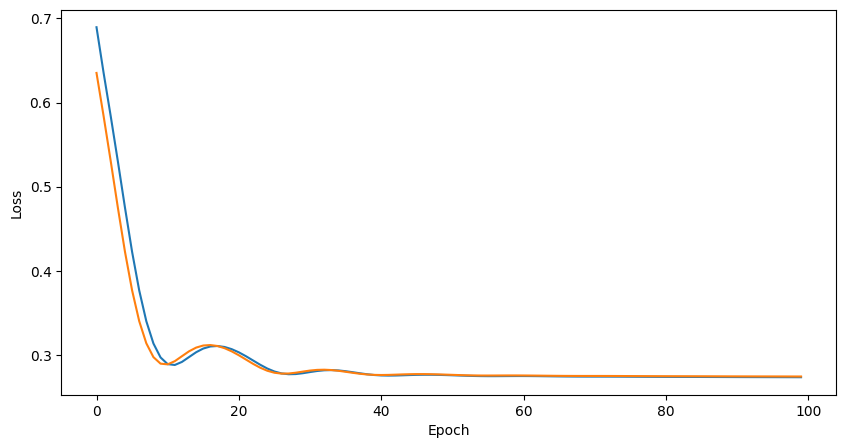

In [18]:
# PLot losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [20]:
model.eval()
model_output = model(X_test_tensor).detach()
output_scores_numpy = torch.sigmoid(model_output).numpy()
y_pred = np.round(output_scores_numpy)

In [21]:
from sklearn.metrics import roc_auc_score

roc_auc_score(Y_test.reshape(-1,1),y_pred)

np.float64(0.888600362967346)